In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from operator import itemgetter


folder = "../trictrac_database"

In [20]:
avis_clean = pd.read_csv(f'{folder}/avis_clean.csv', header=None, names=["Game id", "User id", "Game name UI", "Username", "Datetime", "Rating", "Comment title", "Comment body"]).drop_duplicates()
users = pd.read_csv(f'{folder}/users.csv', header=None, names = ["Username", "User id"]).drop_duplicates()
avis_clean["Datetime"] = pd.to_datetime(avis_clean["Datetime"])

In [3]:
fig = plt.figure(figsize=(10, 5))


<Figure size 1000x500 with 0 Axes>

In [4]:
# Users visualization
def plot_hist_counter(counter, ax, labels = False, rotation=90, sorted=False):
    """Plot histogram where X : category, Y : number of games in this category"""
    
    ax.clear()
    freqs = counter.values()
    
    categories = list(counter.keys())
    if sorted:
        categories.sort()

    x_coords = np.arange(stop = len(categories))

    bars = ax.bar(x_coords, height=freqs)

    if np.nan in categories: # change NaN bar color to red
        bars[categories.index(np.nan)].set_color('r')

    if labels:
        ax.xaxis.set_visible(True)
        ax.tick_params(axis='x', labelrotation=rotation)
        ax.set_xticks(range(len(categories)))  # Set the tick positions
        ax.set_xticklabels(categories)
        ax.xaxis.set_major_locator(plt.FixedLocator(x_coords))
    else:
        ax.xaxis.set_visible(False)

    return ax

In [5]:
ids = Counter(avis_clean["User id"])
names = Counter(avis_clean["Username"])

# Verification to safely plot Username instead of User id
for id, name in avis_clean[["User id", "Username"]].itertuples(index = False):
    if ids[id] != names[name]:
        print(id, name)

1695


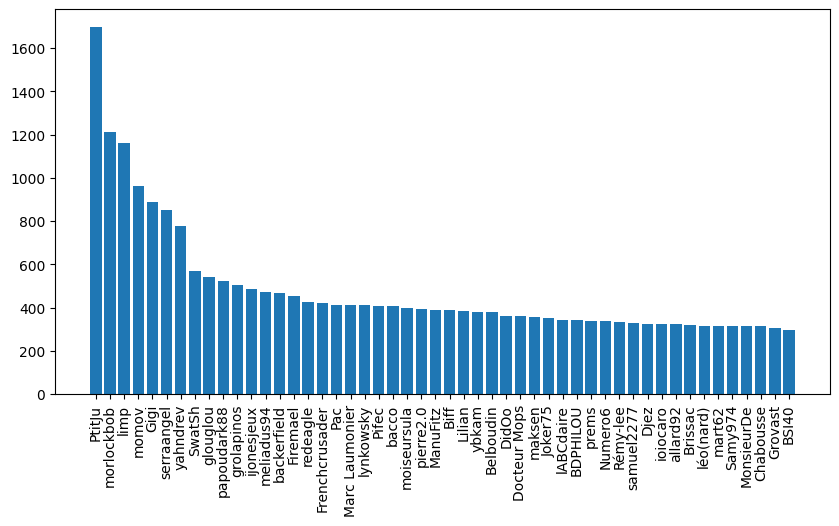

In [6]:
# Plot users by number of theirs reviews
fig.clear()
fig.set_figheight(5)

ax = plot_hist_counter(dict(names.most_common(50)), fig.add_subplot(111), True)
print(max(names.values()))
fig

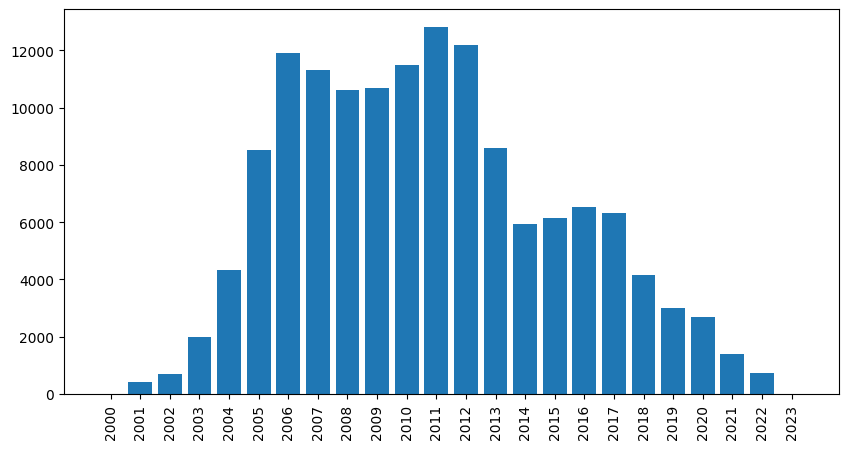

In [7]:
# Plot activity by years
dt_valid = avis_clean[~avis_clean["Datetime"].isna()]
years_counter = Counter(dt_valid["Datetime"].dt.year)  # sort by years in asc

fig.clear()
plot_hist_counter(dict(sorted(years_counter.items(), key=itemgetter(0))), fig.add_subplot(111), True)
fig

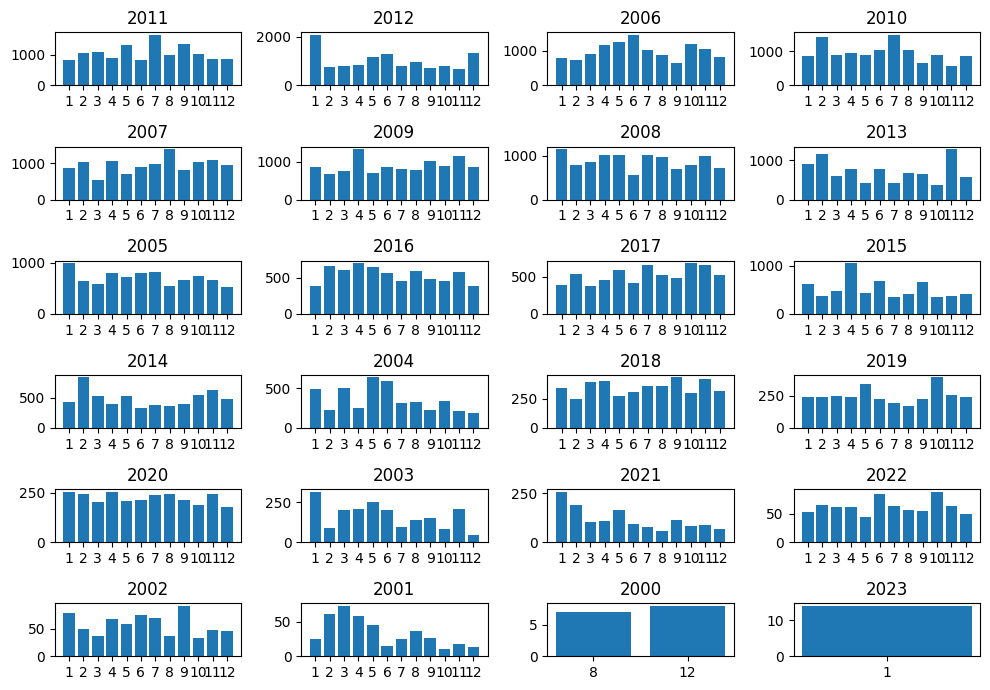

In [8]:
# Plot activity by months for all years. Years are ranged from the most to the least active ones  
def plot_months(ym_counter, fig):
    years = list(ym_counter.keys())

    for i in range(0, len(ym_counter)):  
        ax = fig.add_subplot(len(ym_counter) // 4, 4, i+1)  # grid 
        plot_hist_counter(ym_counter[years[i]], ax, True, rotation=0, sorted=True)
        ax.set_title(f"{years[i]}")

    fig.tight_layout()
    
ym_counter = dict()
fig.set_figheight(7)

years_counter_common = years_counter.most_common()
for year, _ in years_counter_common:
    ym_counter[year] = Counter(dt_valid.loc[dt_valid["Datetime"].dt.year == year, "Datetime"].dt.month)
fig.clear()
plot_months(ym_counter, fig)
fig


In [35]:
def plot_hist_ratings(data, ax, x_label=None, y_label=None, title=None, min_x=0., max_x=10., interval=0.5, bins_factor=25):
    ax.hist(data, range=[min_x, max_x], bins=int(max_x - min_x) * bins_factor)
    ax.set_xticks(np.arange(min_x, max_x+interval, interval))

    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label)
    if title:
        ax.set_title(title)

def scatter_ratings(x, y, ax, x_label, y_label, point_label, title=None):
    ax.scatter(x, y, s=2, label=point_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    if title:
        ax.set_title(title)


In [10]:
# Distribution of average ratings
all_ratings = avis_clean[["Game id", "Rating"]][~avis_clean["Rating"].isna()].groupby(by="Game id")
ratings_means = all_ratings.mean()
ratings_counts = all_ratings.count()

ratings_stats = pd.concat([ratings_means, ratings_counts], axis=1)
ratings_stats.columns = ["Mean", "Number of reviews"]
ratings_stats

,Mean,Number of reviews
Game id,,
0,2.000000,1
1,9.333333,3
2,6.333333,6
3,8.000000,2
4,6.390909,11
...,...,...
10544,10.000000,2
10545,3.000000,2
10546,7.037143,140


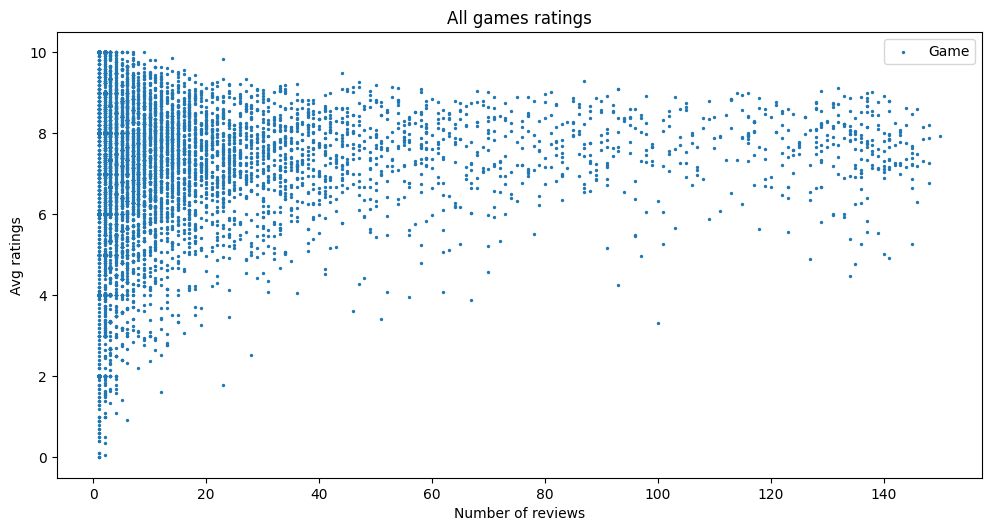

In [38]:
fig.clear()
fig.set_figheight(5)
scatter_ratings(ratings_stats["Number of reviews"], ratings_stats["Mean"], fig.add_subplot(111),
                x_label="Number of reviews", y_label="Avg ratings", point_label="Game", title="All games ratings")
fig

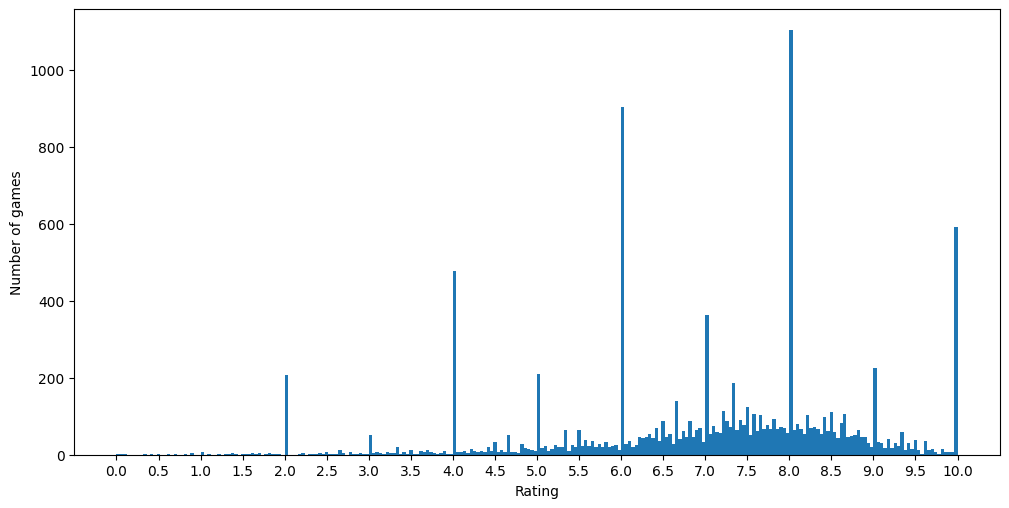

In [12]:
fig.set_figheight(5)

fig.clear()
plot_hist_ratings(ratings_means["Rating"], fig.add_subplot(111), "Rating", "Number of games")
fig

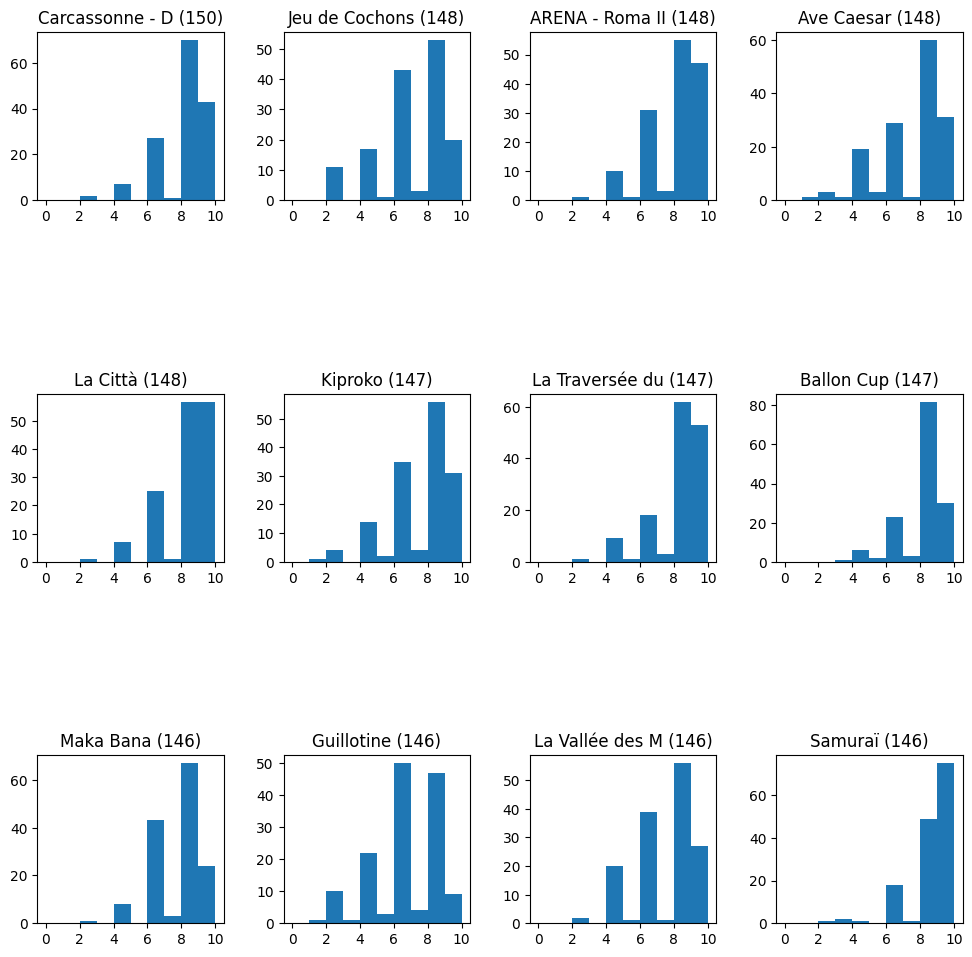

In [13]:
# 1. Take top N (= 12) most popular games (nb_reviews > 30), draw the distribution of their ratings
ids_review_counter = Counter(avis_clean["Game id"]).most_common(12)
ratings_valid = avis_clean[["Game name UI", "Rating"]][~avis_clean["Rating"].isna()]

# Replace game IDs by UI names
names_review_counter = dict()
for id, count in ids_review_counter:
    gamename = avis_clean["Game name UI"][avis_clean["Game id"] == id].iloc[0]

    if gamename in names_review_counter:
        print(f"Attention! {gamename} has multiple IDs")

    names_review_counter[gamename] = count

names_review_counter = list(names_review_counter.items())

fig.set_figheight(10)
fig.clear()

for i in range(12):
    ax = fig.add_subplot(3, 4, i+1)
    gamename, count = names_review_counter[i]
    #print(ratings_valid["Rating"][ratings_valid["Game name UI"] == gamename])
    plot_hist_ratings(ratings_valid["Rating"][ratings_valid["Game name UI"] == gamename], ax=ax, title=f"{gamename[:15]} ({count})", interval=2, bins_factor=1)

fig


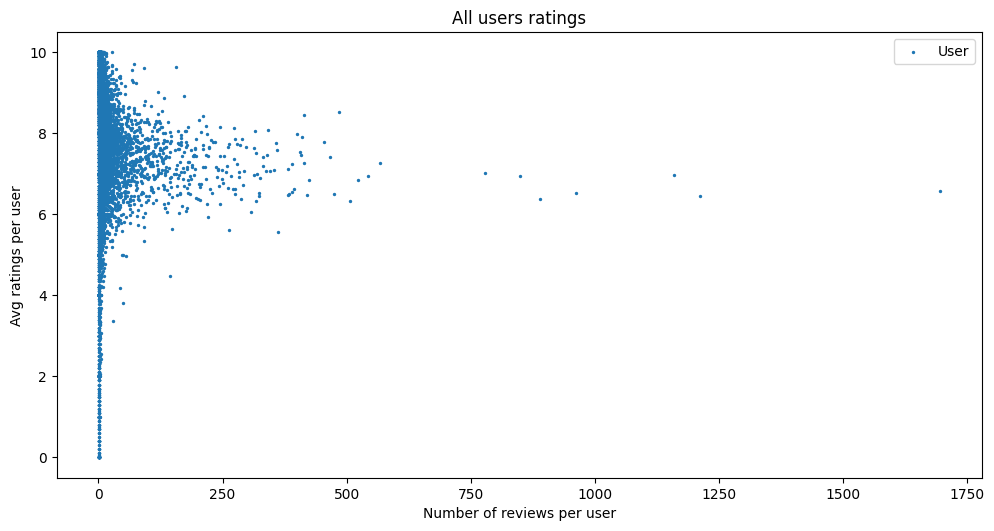

In [58]:
# Users ratings analysis
avis_clean.head()

users_ratings = avis_clean[["Username", "Rating"]].groupby("Username").agg(count=("Rating","count"), mean=("Rating", "mean")).reset_index()
fig.set_figheight(5)
fig.clear()
scatter_ratings(users_ratings["count"], users_ratings["mean"], fig.add_subplot(111),
                x_label="Number of reviews per user", y_label="Avg ratings per user",
                point_label="User", title="All users ratings")
fig

In [188]:
def violin_plot(data, ax, data_labels, y_label, title, rotation=90):
    ax.violinplot(data, showextrema=True, showmeans=True)

    labels_coords = np.arange(start=1, stop = data.index.size+1)
    
    if data_labels is not None:
        ax.tick_params(axis='x', labelrotation=rotation)
        ax.set_xticks(np.arange(start=1, stop=data.index.size+1))  # Set the tick positions
        ax.set_xticklabels(data_labels)
        ax.xaxis.set_major_locator(plt.FixedLocator(labels_coords))

        
    ax.set_ylabel(y_label)
    ax.set_title(title)

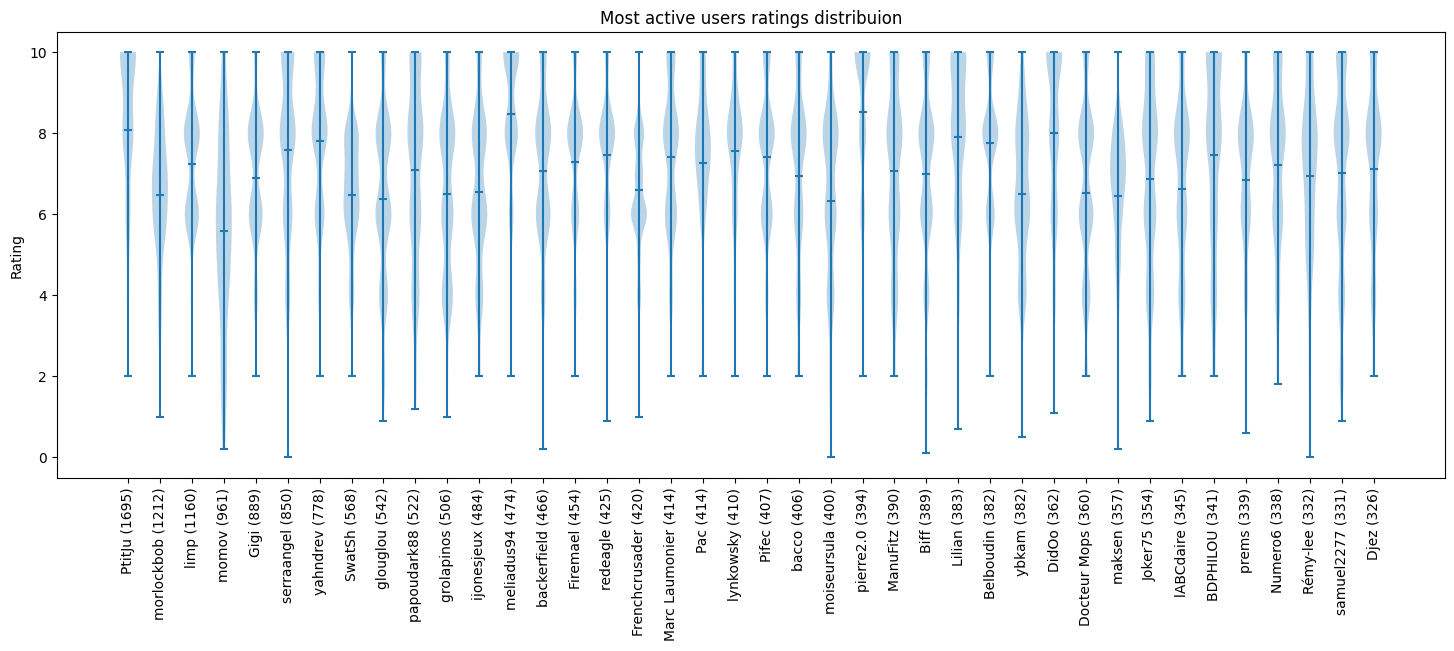

In [189]:
# Choose most active users (top X number of reviews based)

top_users = users_ratings.nlargest(n=40, columns="count")
top_users_merged = top_users.merge(avis_clean[["Username", "Rating"]], on="Username")
violinplot_data = top_users_merged[["Username", "Rating"]].groupby(by="Username")["Rating"].apply(np.array)
fig.set_figwidth(15)
fig.clear()
violin_plot(violinplot_data, ax=fig.add_subplot(111),
            data_labels=np.vectorize(lambda user, count: f"{user} ({count})")(top_users["Username"], top_users["count"]),
            y_label="Rating", title="Most active users ratings distribuion", rotation=90)
fig

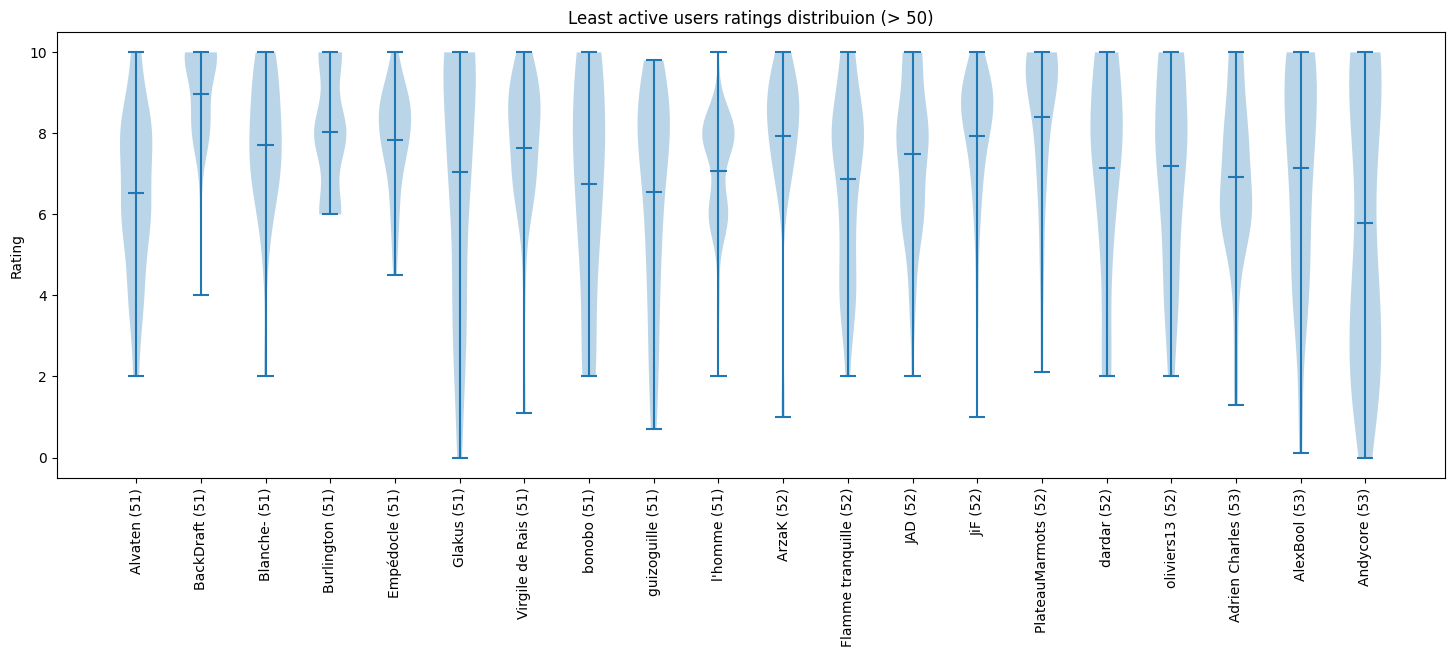

In [202]:
# Least active users (number of reviews based). Number of reviews > min_nb_rev
min_nb_rev = 50
bottom_users = users_ratings[users_ratings["count"] > min_nb_rev].nsmallest(n=20, columns="count")
bottom_users_merged = bottom_users.merge(avis_clean[["Username", "Rating"]], on="Username")
violinplot_data = bottom_users_merged[["Username", "Rating"]].groupby("Username")["Rating"].apply(np.array)

fig.set_figwidth(15)
fig.clear()
violin_plot(violinplot_data, ax=fig.add_subplot(111),
            data_labels=np.vectorize(lambda user, count: f"{user} ({count})")(bottom_users["Username"], bottom_users["count"]),
            y_label="Rating", title=f"Least active users ratings distribuion (> {min_nb_rev})", rotation=90)
fig

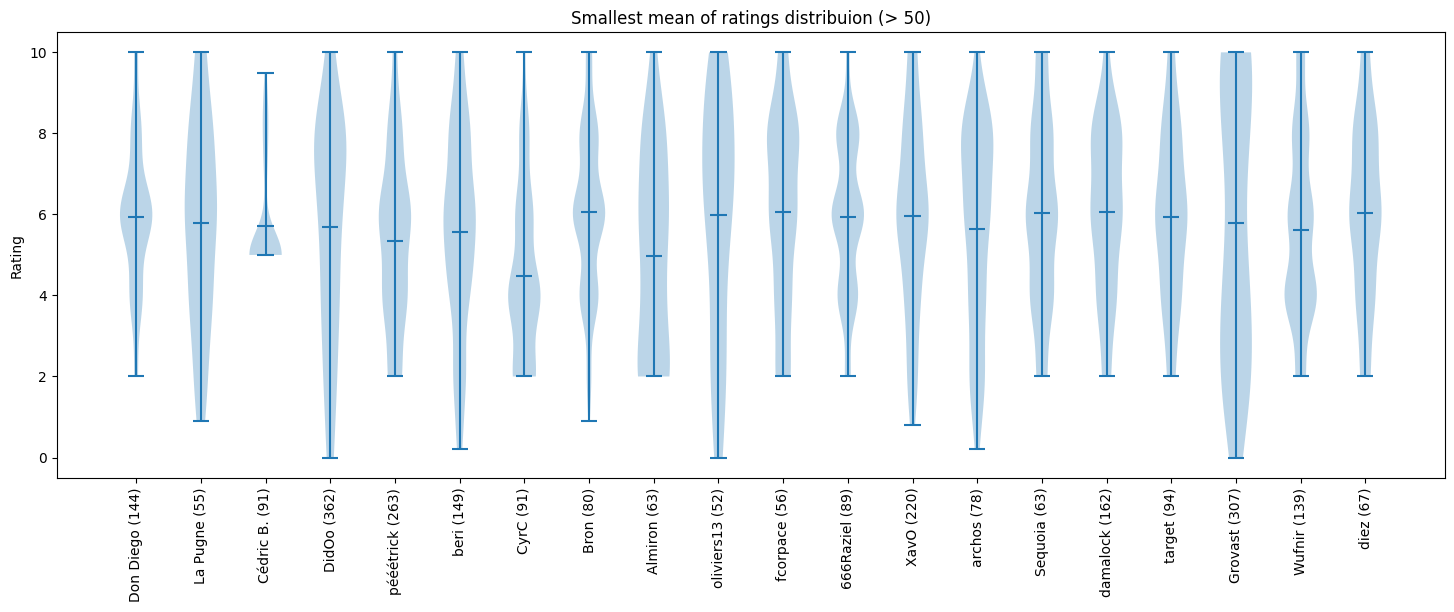

In [201]:
# Least active users (number of reviews based). Number of reviews > min_nb_rev
bottom_users = users_ratings[users_ratings["count"] > min_nb_rev].nsmallest(n=20, columns="mean")
bottom_users_merged = bottom_users.merge(avis_clean[["Username", "Rating"]], on="Username")
violinplot_data = bottom_users_merged[["Username", "Rating"]].groupby("Username")["Rating"].apply(np.array)

fig.set_figwidth(15)
fig.clear()
violin_plot(violinplot_data, ax=fig.add_subplot(111),
            data_labels=np.vectorize(lambda user, count: f"{user} ({count})")(bottom_users["Username"], bottom_users["count"]),
            y_label="Rating", title=f"Smallest mean of ratings distribuion (> {min_nb_rev})", rotation=90)
fig

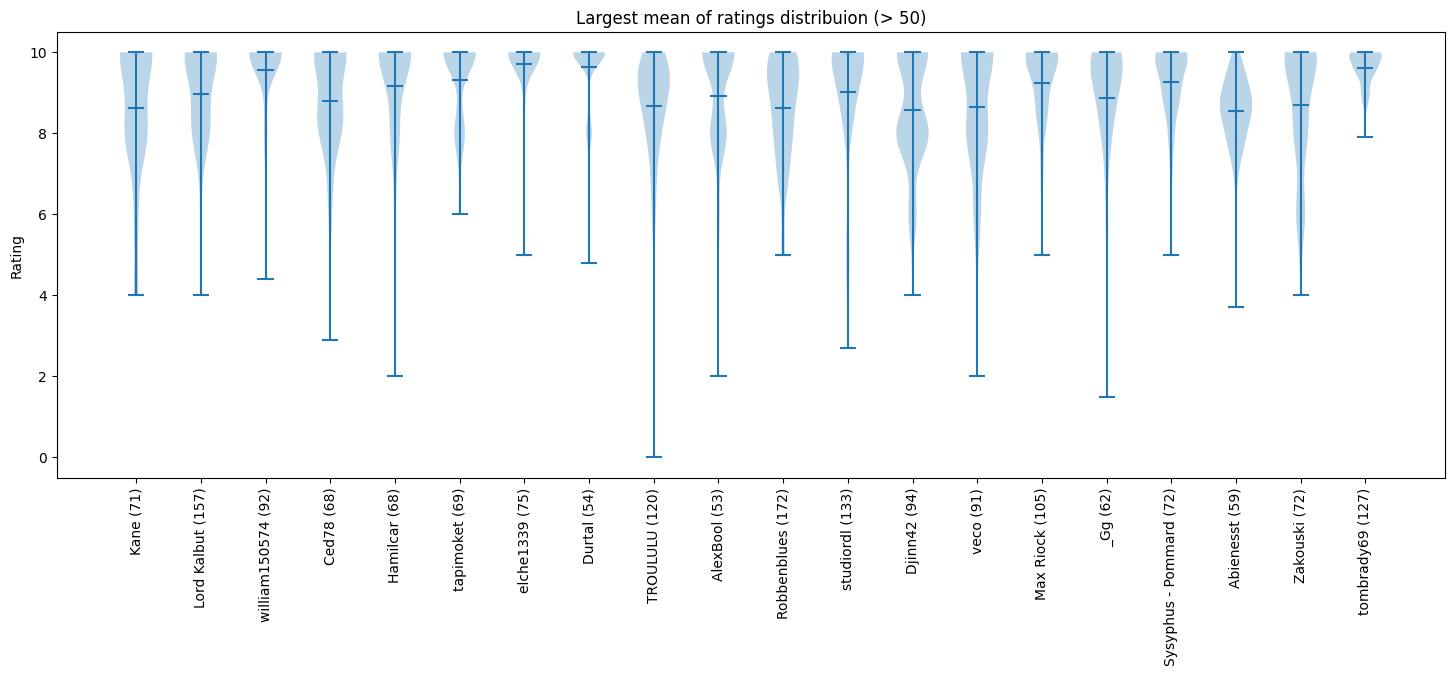

In [200]:
# Least active users (number of reviews based). Number of reviews > min_nb_rev
top_users = users_ratings[users_ratings["count"] > min_nb_rev].nlargest(n=20, columns="mean")
top_users_merged = top_users.merge(avis_clean[["Username", "Rating"]], on="Username")
violinplot_data = top_users_merged[["Username", "Rating"]].groupby("Username")["Rating"].apply(np.array)

fig.set_figwidth(15)
fig.clear()
violin_plot(violinplot_data, ax=fig.add_subplot(111),
            data_labels=np.vectorize(lambda user, count: f"{user} ({count})")(top_users["Username"], top_users["count"]),
            y_label="Rating", title=f"Largest mean of ratings distribuion (> {min_nb_rev})", rotation=90)
fig